# XEEK Find Ancient River Channels
### Gamma-log facies identification
This challenge will have you use rock radioactivity measurements to identify which body of water created them

https://www.xstarter.xyz/challenge-details/gamma-log-facies-identification#

#### 0. <a href=#Prepare-conda-environment>Prepare conda environment</a> 
#### 1. <a href=#Load-Python-Libraries>Load packages</a> 
#### 2. <a href=#Load-train-and-test-data>Load train and test files</a> 
#### 3. <a href=#Check-the-data>Check the data</a> 
#### 4. <a href=#Building-some-useful-functions>Building some useful functions</a> 
#### 5. <a href=#Feature-engineering>Feature engineering</a>
#### 6. <a href=#Prepare-the-test-set-for-submision>Prepare the test set for submision</a>
#### 7. <a href=Generate-submission-file> Generate submission file</a>

#### 0. Prepare conda environment
Please make sure if you are using any python package which is not included in the anaconda standard package (either for <a href=https://repo.anaconda.com/archive/Anaconda3-2019.10-MacOSX-x86_64.pkg>Mac</a>/<a href=https://repo.anaconda.com/archive/Anaconda3-2019.10-Windows-x86_64.exe>Windowns</a>/<a href=https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh>Linux</a> Anaconda3-2019.10-x86-64 to be included in the final notebook as:

__!pip install package_name=package_version__ 

"!" will execute your command in the notebook

Exmaple: 

!pip install pandas==0.22.0

#### 1. Load Python Libraries

In [1]:
# load libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML model
from sklearn.ensemble import GradientBoostingClassifier

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
%matplotlib inline

# audio file for long calculations
from IPython.display import Audio
sound_file = 'button-2.wav'

#### 2. Load train and test data
Please not the path and file names should stay intact. Otherwise for the final submission XEEK team may not be able to run your jupyter nootbook.

In [2]:
# path to train and test files - create pandas dataframes for training and test sets
train_path = "train_lofi_rowid_Nov13.csv"
trainDF = pd.read_csv(train_path)

final_test_path = "test_lofi_rowid_Nov13.csv"
testDF = pd.read_csv(final_test_path)

#### 3. Check the data for train and test sets
Data set has GR and labels for 4000 wells. There are 4 main columns in the data frame:
* row_id: Each well has 1100 rows and a random number of log facies. The row_id column represents depth in the well.
* well_id: each well has a unique ID
* GR: Gamma Ray or GAMMA log and it is noisy. 
* label: label is the log facies label and it can hold values from 0 to 4.  0: no label, 1: symmetrical, 2: cylindrical, 3: funnel, and 4: bell

Test set does not contain the label column and we need to calculate and submit it for the competition.

In [3]:
# show trainDF and testDF dimensions and top of data frame
print("Train shape:", trainDF.shape)
display(trainDF.head())

# the testDF is a bit shorter and lacks the labels and need to be predicted
print("Test shape:", testDF.shape)
testDF.head()

Train shape: (4400000, 4)


,row_id,well_id,GR,label
0,0,0,99.005617,0
1,1,0,105.563944,0
2,2,0,105.921065,0
3,3,0,113.513354,0
4,4,0,101.523783,0


Test shape: (385000, 3)


,row_id,well_id,GR
0,0,5000,134.943504
1,1,5000,127.004675
2,2,5000,133.159255
3,3,5000,134.411762
4,4,5000,135.748644


In [4]:
# count the row entries for each well_id - they are all 1100
trainDF["well_id"].value_counts()

3998    1100
1328    1100
1341    1100
1340    1100
1339    1100
        ... 
2660    1100
2661    1100
2658    1100
2659    1100
0       1100
Name: well_id, Length: 4000, dtype: int64

In [5]:
testDF["well_id"].value_counts()

5117    1100
5237    1100
5229    1100
5234    1100
5235    1100
        ... 
5051    1100
5307    1100
5048    1100
5304    1100
5122    1100
Name: well_id, Length: 350, dtype: int64

0    2326115
1     521372
4     519394
2     518039
3     515080
Name: label, dtype: int64


Text(0.5, 0, 'Lable')

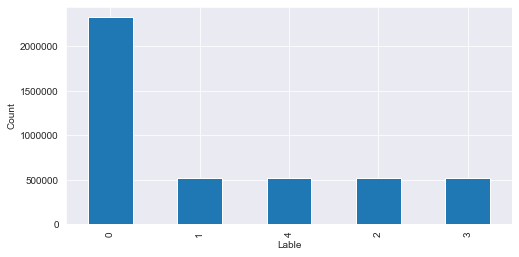

In [6]:
# numerical count of each facies/label kind
print(trainDF["label"].value_counts())

# plot graph of label distribution
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
trainDF["label"].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Lable')

In [7]:
# statistical description of trainDF - set style of float numbers
pd.set_option('float_format', '{:.2f}'.format)
trainDF.describe()

,row_id,well_id,GR,label
count,4400000.00,4400000.00,4400000.00,4400000.00
mean,549.50,1999.50,97.60,1.18
std,317.54,1154.70,32.06,1.46
min,0.00,0.00,19.47,0.00
25%,274.75,999.75,65.69,0.00
50%,549.50,1999.50,107.51,0.00
75%,824.25,2999.25,123.55,2.00
max,1099.00,3999.00,161.87,4.00


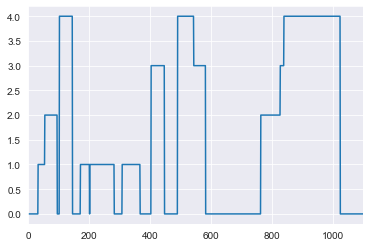

In [8]:
# plot the facies labels of the first well
trainDF[trainDF.well_id==0].label.plot()

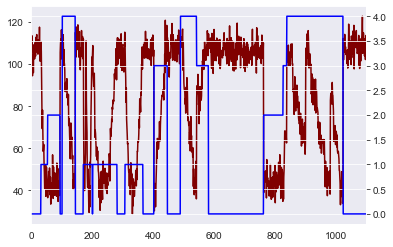

In [9]:
# plot the facies labels and Gamma Ray curve of the first well
axl = trainDF[trainDF.well_id==0].GR.plot(color='maroon')
axr = trainDF[trainDF.well_id==0].label.plot(color='blue',secondary_y=True)

#### 4. Building some useful functions
Smoothing/denoising functions for GR values.

Some other functions for understaing the data better.


In [10]:
# some useful function to process data
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    # ifs for exception output
    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    
    # define windows
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    # print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    
    return y



def countSimilarConsectiveNums(lst):
    resVal = []
    resCnt = []
    val = -1
    cnt = 0
    prevVal = lst[0]
    for ii in range(1,len(lst)):
        #print(lst[ii])
        val = lst[ii]
        cnt +=1
        if prevVal!=val:
            #print(prevVal,val)
            resVal.append(prevVal)
            resCnt.append(cnt)
            prevVal = val
            cnt = 0
    resVal.append(prevVal)
    resCnt.append(cnt+1)
    
    return (resVal, resCnt)



def countSimilarConsectiveNumsStats(lst):
    resVal = []
    resCnt = []
    val = -1
    cnt = 0
    prevVal = lst[0]
    for ii in range(1,len(lst)):
        #print(lst[ii])
        val = lst[ii]
        cnt +=1
        if prevVal!=val:
            #print(prevVal,val)
            resVal.append(prevVal)
            resCnt.append(cnt)
            prevVal = val
            cnt = 0
    resVal.append(prevVal)
    resCnt.append(cnt+1)
    
    res = {}
    res["resVal"] = np.array(resVal)
    res["resCnt"] = np.array(resCnt)
    res["firstLabel"] = lst[0]
    res["lastLabel"] = lst[-1]
    res["firstLabelWinSize"] = resCnt[0]
    res["lastLabelWinSize"] = resCnt[-1]
    res["minCnt"] = min(resCnt)
    res["maxCnt"] = max(resCnt)
    res["resNonZeroVal"] = np.array(resVal)[np.array(resVal)>0]
    res["resNonZeroCnt"] = np.array(resCnt)[np.array(resVal).nonzero()]
    
    return (res)

#countSimilarConsectiveNums([1,1,1,1,4,4,4,4,4,5,5,1,3,3,3,0,0,0,0,0])                    

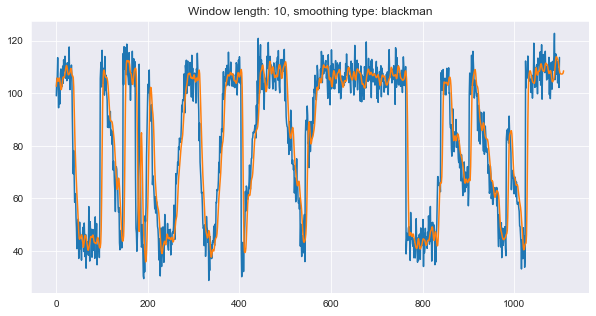

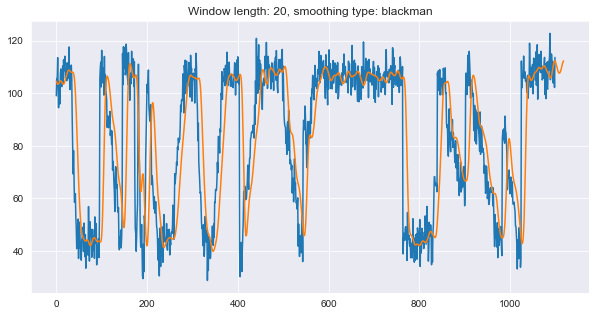

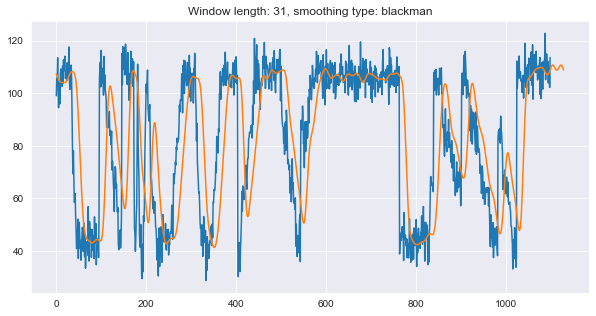

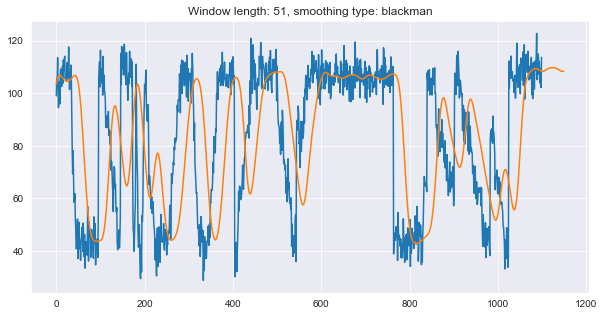

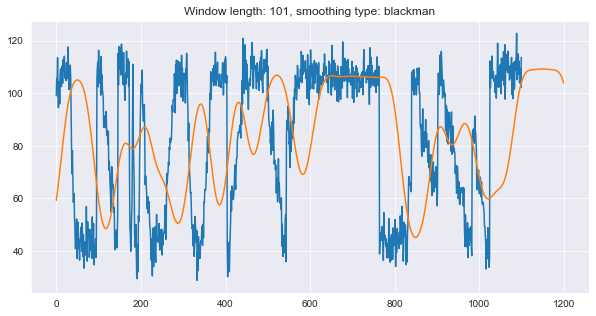

In [11]:
# smoothing the signal - finding the best window length

# define series of smoothing types
#windows = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
windows = ['blackman']

# define  series of window lengths
wls = [10,20,31,51,101]

for wl in wls:
    for w in windows:
        plt.figure(figsize=(10,5))
        
        # original plot
        plt.plot(trainDF[trainDF.well_id==0].GR)
        
        # smoothed plot
        plt.plot(smooth(trainDF[trainDF.well_id==0].GR,wl,w))
        
        # title
        label = "Window length: {}, smoothing type: {}".format(wl, w)
        plt.title(label, fontdict=None, loc='center', pad=None)
        
        plt.show()

# seems hamming with wl=31 works the best???

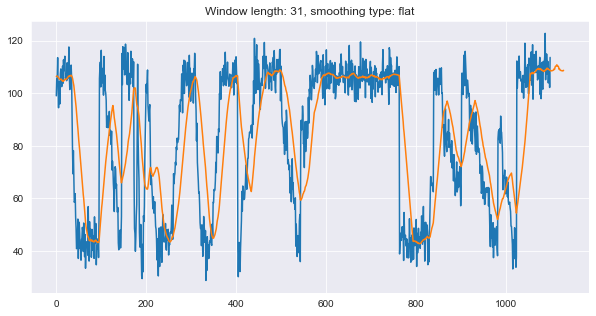

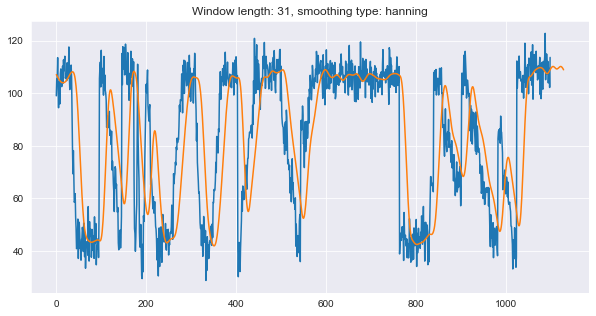

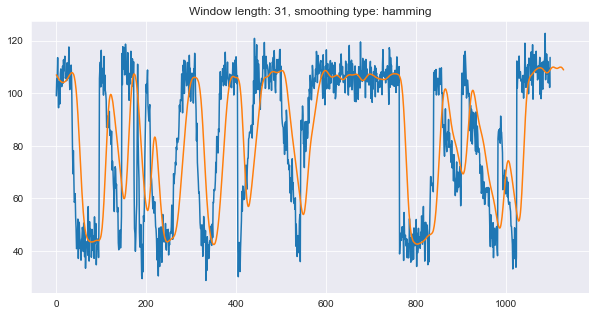

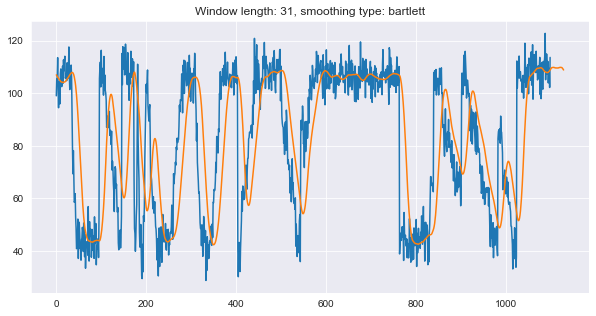

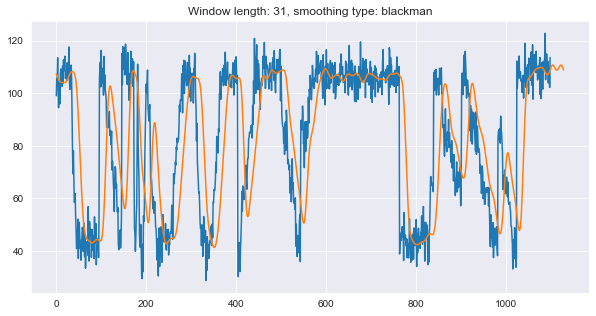

In [12]:
# smoothing the signal - finding the best smoothing algo, fixed length

wl = 31

windows = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

for w in windows:
    plt.figure(figsize=(10,5))
    
    # original plot
    plt.plot(trainDF[trainDF.well_id==0].GR)
    
    # smoothed plot
    plt.plot(smooth(trainDF[trainDF.well_id==0].GR,wl,w))#hanning with window len 31 seems the best
    
    # title
    label = "Window length: {}, smoothing type: {}".format(wl, w)
    plt.title(label, fontdict=None, loc='center', pad=None)
    
    plt.show()

In [13]:
# run the functions for counting labels and their lengths on the first well
countSimilarConsectiveNums(trainDF[trainDF.well_id==0].label.tolist())

([0, 1, 2, 0, 4, 0, 1, 0, 1, 0, 1, 0, 3, 0, 4, 3, 0, 2, 3, 4, 0],
 [33,
  22,
  41,
  7,
  43,
  26,
  30,
  1,
  80,
  26,
  59,
  36,
  44,
  43,
  53,
  39,
  181,
  64,
  12,
  185,
  75])

In [14]:
# run the functions for counting labels and their lengths on the first well
countSimilarConsectiveNumsStats(trainDF[trainDF.well_id==0].label.tolist())

{'resVal': array([0, 1, 2, 0, 4, 0, 1, 0, 1, 0, 1, 0, 3, 0, 4, 3, 0, 2, 3, 4, 0]),
 'resCnt': array([ 33,  22,  41,   7,  43,  26,  30,   1,  80,  26,  59,  36,  44,
         43,  53,  39, 181,  64,  12, 185,  75]),
 'firstLabel': 0,
 'lastLabel': 0,
 'firstLabelWinSize': 33,
 'lastLabelWinSize': 75,
 'minCnt': 1,
 'maxCnt': 185,
 'resNonZeroVal': array([1, 2, 4, 1, 1, 1, 3, 4, 3, 2, 3, 4]),
 'resNonZeroCnt': array([ 22,  41,  43,  30,  80,  59,  44,  53,  39,  64,  12, 185])}

In [15]:
# Most of the first rows' GR values for wells ar 0
trainDF.groupby("well_id").first().label.value_counts()

0    3940
1      17
4      15
3      14
2      14
Name: label, dtype: int64

In [16]:
# all the last rows' GR values for wells ar 0
trainDF.groupby("well_id").last().label.value_counts()

0    4000
Name: label, dtype: int64

In [17]:
trainDF.groupby("well_id").apply(lambda x: countSimilarConsectiveNumsStats(x.label.tolist())["lastLabelWinSize"]).min()

14

In [18]:
trainDF.groupby("well_id").apply(lambda x: countSimilarConsectiveNumsStats(x.label.tolist())["resNonZeroCnt"].min())

well_id
0       12
1        2
2        9
3        9
4        9
        ..
3995    23
3996    18
3997    16
3998     9
3999    13
Length: 4000, dtype: int64

In [19]:
np.nonzero([0, 3, 0, 1, 3, 0, 4, 1, 4, 2, 0, 2, 0, 1, 2, 1, 0, 3, 0])

(array([ 1,  3,  4,  6,  7,  8,  9, 11, 13, 14, 15, 17], dtype=int64),)

#### Check if there is any spatial **autocorrelation** in GR values. Only tested on the first well
*Pre smoothing*

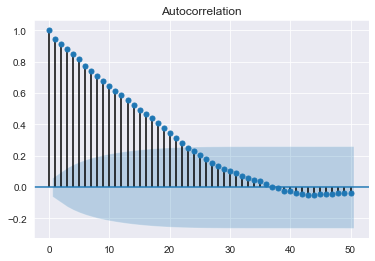

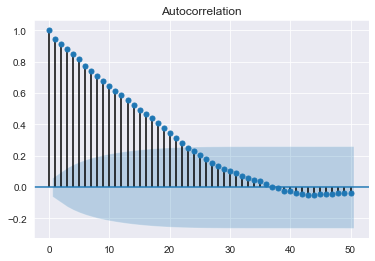

In [20]:
# Plot the autocorrelation function (ACF) for Well 0 - Correlation of a signal with a delayed copy of itself as a function of delay/lag
plot_acf(trainDF[trainDF.well_id==0].GR,lags=50)

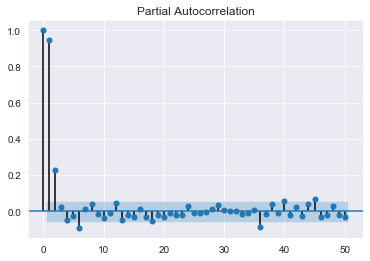

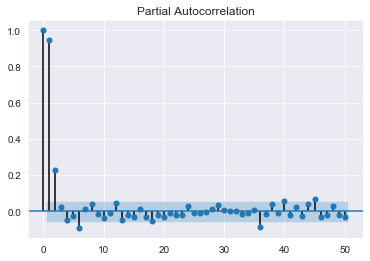

In [21]:
# Plot the PARTIAL autocorrelation function (PACF) for Well 0 - Correlation of a signal with a delayed copy of itself as a function of delay/lag with the effect of the intervening correlations removed
plot_pacf(trainDF[trainDF.well_id==0].GR,lags=50)

*Post smoothing*

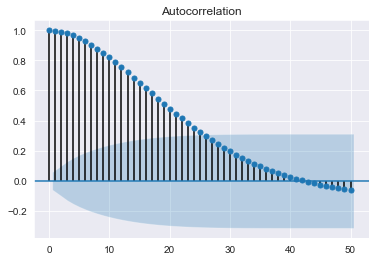

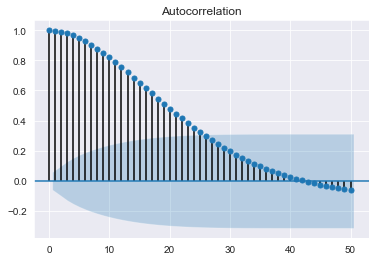

In [22]:
# Plot the autocorrelation function (ACF) for Well 0 *smoothed*
plot_acf(smooth(trainDF[trainDF.well_id==0].GR,31,"hanning"),lags=50)

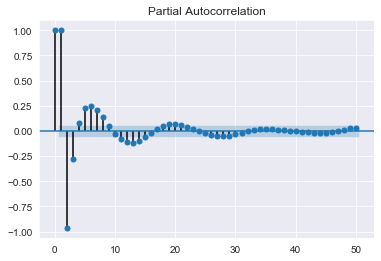

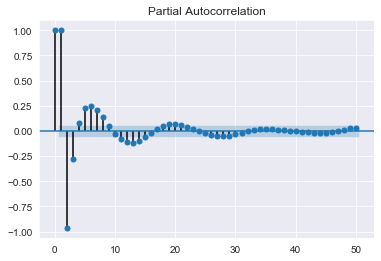

In [23]:
# Plot the PARTIAL autocorrelation function (PACF) for Well 0 *smoothed*
plot_pacf(smooth(trainDF[trainDF.well_id==0].GR,31,"hanning"),lags=50)

#### 5. Feature engineering (calculate new columns)
By adding N (featureWinLen=5) of the GR values from before/after the current row as our extra features we can build better classifier

In [24]:
# Feature engineering. Using previous/next 5 signal values as input along with the main GR value
# This is not very correct as it will use signal values from other wells to fill the first 5 and last 5 signals - you can fix it in your own version :)
# Answer: yes, but since the start and ends of all well is always 0 label, it should have little impact??

featureWinLen = 5

for ii in range(1,featureWinLen+1):
    # upward shift (positive = added to index, fetches GR from 5 steps deeper in well)
    trainDF["GR+"+str(ii)] = trainDF["GR"].shift(ii)
    trainDF["GR+"+str(ii)].fillna(trainDF.GR, inplace=True)
    
    # downward shift (negative = subtracts from index, fetches GR from 5 stepsshallower in well)
    trainDF["GR"+str(-ii)] = trainDF["GR"].shift(-ii)
    trainDF["GR"+str(-ii)].fillna(trainDF.GR, inplace=True)

# show modified DF
display(trainDF.head())
trainDF.tail()

,row_id,well_id,GR,label,GR+1,GR-1,GR+2,GR-2,GR+3,GR-3,GR+4,GR-4,GR+5,GR-5
0,0,0,99.01,0,99.01,105.56,99.01,105.92,99.01,113.51,99.01,101.52,99.01,94.46
1,1,0,105.56,0,99.01,105.92,105.56,113.51,105.56,101.52,105.56,94.46,105.56,103.86
2,2,0,105.92,0,105.56,113.51,99.01,101.52,105.92,94.46,105.92,103.86,105.92,104.41
3,3,0,113.51,0,105.92,101.52,105.56,94.46,99.01,103.86,113.51,104.41,113.51,95.93
4,4,0,101.52,0,113.51,94.46,105.92,103.86,105.56,104.41,99.01,95.93,101.52,107.29


,row_id,well_id,GR,label,GR+1,GR-1,GR+2,GR-2,GR+3,GR-3,GR+4,GR-4,GR+5,GR-5
4399995,1095,3999,123.02,0,122.17,117.47,113.47,118.93,122.83,127.45,120.39,126.54,115.95,123.02
4399996,1096,3999,117.47,0,123.02,118.93,122.17,127.45,113.47,126.54,122.83,117.47,120.39,117.47
4399997,1097,3999,118.93,0,117.47,127.45,123.02,126.54,122.17,118.93,113.47,118.93,122.83,118.93
4399998,1098,3999,127.45,0,118.93,126.54,117.47,127.45,123.02,127.45,122.17,127.45,113.47,127.45
4399999,1099,3999,126.54,0,127.45,126.54,118.93,126.54,117.47,126.54,123.02,126.54,122.17,126.54


#### Splitting

In [25]:
# Split the train DF in training and validation -- for simplicity we use first 100,000 rows as our training data set and the second 100,000 as validation (remember, this is about 91 of 4,000 wells. The whole set is 4,400,000 entries)

trainDataSet_X = trainDF.loc[:100000,:].drop(["row_id","well_id","label"],1)
trainDataSet_Y = trainDF.loc[:100000,"label"]

valDataSet_X = trainDF.loc[100000:200000,:].drop(["row_id","well_id","label"],1)
valDataSet_Y = trainDF.loc[100000:200000,"label"]

# test Y is missing, obviously
testDataSet_X = testDF.drop(["row_id","well_id"],1)

In [26]:
print("Train X")
display(trainDataSet_X.head())

print("Val X")
display(valDataSet_X.head())

print("Test X")
display(testDataSet_X.head())

print("Train X Shape:",trainDataSet_X.shape,"\nTrain Y Shape:",trainDataSet_Y.shape,"\nValidation X Shape:",valDataSet_X.shape,"\nValidation Y Shape:",valDataSet_Y.shape, "\nTest X shape:", testDataSet_X.shape)

Train X


,GR,GR+1,GR-1,GR+2,GR-2,GR+3,GR-3,GR+4,GR-4,GR+5,GR-5
0,99.01,99.01,105.56,99.01,105.92,99.01,113.51,99.01,101.52,99.01,94.46
1,105.56,99.01,105.92,105.56,113.51,105.56,101.52,105.56,94.46,105.56,103.86
2,105.92,105.56,113.51,99.01,101.52,105.92,94.46,105.92,103.86,105.92,104.41
3,113.51,105.92,101.52,105.56,94.46,99.01,103.86,113.51,104.41,113.51,95.93
4,101.52,113.51,94.46,105.92,103.86,105.56,104.41,99.01,95.93,101.52,107.29


Val X


,GR,GR+1,GR-1,GR+2,GR-2,GR+3,GR-3,GR+4,GR-4,GR+5,GR-5
100000,89.91,92.63,88.62,87.59,87.52,97.31,74.52,83.14,78.64,94.14,67.50
100001,88.62,89.91,87.52,92.63,74.52,87.59,78.64,97.31,67.50,83.14,74.09
100002,87.52,88.62,74.52,89.91,78.64,92.63,67.50,87.59,74.09,97.31,60.64
100003,74.52,87.52,78.64,88.62,67.50,89.91,74.09,92.63,60.64,87.59,69.59
100004,78.64,74.52,67.50,87.52,74.09,88.62,60.64,89.91,69.59,92.63,59.18


Test X


,GR
0,134.94
1,127.00
2,133.16
3,134.41
4,135.75


Train X Shape: (100001, 11) 
Train Y Shape: (100001,) 
Validation X Shape: (100001, 11) 
Validation Y Shape: (100001,) 
Test X shape: (385000, 1)


#### Pre-processing

In [27]:
from sklearn import preprocessing

scaler_train_X = preprocessing.StandardScaler().fit(trainDataSet_X)
scaled_trainDataSet_X = scaler_train_X.transform(trainDataSet_X)

scaler_val_X = preprocessing.StandardScaler().fit(valDataSet_X)
scaled_valDataSet_X = scaler_val_X.transform(valDataSet_X)

scaler_test_X = preprocessing.StandardScaler().fit(testDataSet_X)
scaled_testDataSet_X = scaler_test_X.transform(testDataSet_X)

print("Scaled Train X:",scaled_trainDataSet_X[0:5])
print("\nScaled Val X:",scaled_valDataSet_X[0:5])
print("\nScaled Test X:",scaled_testDataSet_X[0:5])

Scaled Train X: [[ 0.05557299  0.05557015  0.26152079  0.05556607  0.27274076  0.05556032
   0.51116251  0.05555516  0.1346778   0.05554944 -0.0869867 ]
 [ 0.26151762  0.05557015  0.27273513  0.26151071  0.51115376  0.26150497
   0.13466691  0.26149954 -0.08699776  0.261494    0.2082061 ]
 [ 0.27273196  0.26151483  0.51114815  0.05556607  0.13465734  0.27271931
  -0.08700874  0.27271387  0.2081963   0.27270834  0.2253223 ]
 [ 0.51114507  0.27272917  0.13465169  0.26151071 -0.08701879  0.05556032
   0.20818543  0.51112669  0.22531258  0.51112138 -0.04082532]
 [ 0.13464848  0.51114234 -0.08702447  0.27272505  0.20817602  0.26150497
   0.22530172  0.05555516 -0.04083618  0.1346249   0.31578164]]

Scaled Val X: [[-0.21683599 -0.13116822 -0.25728964 -0.28969064 -0.29186705  0.01623306
  -0.70135079 -0.42966323 -0.57142512 -0.08363723 -0.92231347]
 [-0.25728119 -0.21682875 -0.29185749 -0.13115862 -0.70134125 -0.28968483
  -0.57141027  0.01624586 -0.92230111 -0.42965636 -0.71485315]
 [-0.2918

## --Here starts the actual ML stuff--

#### Define a function for a fancier Confusion Matrix

In [28]:
facies_labels = ['0 no label','1 symmetrical','2 cylindrical','3 funnel','4 bell']

def display_cm(cm, labels, hide_zeros=False,
                             display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision and F1 score.
       Based on Zach Guo's print_cm gist at
       https://gist.github.com/zachguo/10296432
    """

    precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
    recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    #print total_precision
    
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + " Pred", end=' ')
    for label in labels: 
        print("%{0}s".format(columnwidth) % label, end=' ')
    print("%{0}s".format(columnwidth) % 'Total')
    print("    " + " True")
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)): 
            cell = "%{0}d".format(columnwidth) % cm[i, j]
            if hide_zeros:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            print(cell, end=' ')
        print("%{0}d".format(columnwidth) % sum(cm[i,:]))
        
    if display_metrics:
        print()
        print("Precision", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % precision[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_precision)
        print("   Recall", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % recall[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_recall)
        print("       F1", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % F1[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_F1)

#### Simple SVM

In [29]:
# run a simplistic Support Vector Machine with scaled features - fit on the Test Set

from sklearn import svm

clf0  = svm.SVC()
clf0.fit(scaled_trainDataSet_X,trainDataSet_Y)
predicted_trainDataSet_Y = clf0.predict(scaled_trainDataSet_X)

Audio(sound_file, autoplay=True)

In [30]:
# evaluate Train Set fit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

conf = confusion_matrix(trainDataSet_Y, predicted_trainDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

print("Train F1: ",round(f1_score(trainDataSet_Y, predicted_trainDataSet_Y, average='micro'),2))
print("Train Accuracy %: ",round(accuracy_score(trainDataSet_Y, predicted_trainDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         52917            85                         157           159         53318
    1 symmetrical           459          3707          3815          2244          1206         11431
    2 cylindrical             1           167         11930            24            46         12168
         3 funnel          2411          1060          1467          5183           462         10583
           4 bell          2737           821          1610           384          6949         12501
Train F1:  0.81
Train Accuracy %:  0.81


In [31]:
# Predict on Val Set and evaluate

predicted_valDataSet_Y = clf0.predict(scaled_valDataSet_X)

conf = confusion_matrix(valDataSet_Y, predicted_valDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

print("Val F1: ",round(f1_score(valDataSet_Y, predicted_valDataSet_Y, average='micro'),2))
print("Val Accuracy %: ",round(accuracy_score(valDataSet_Y, predicted_valDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         53201            81                         150           157         53589
    1 symmetrical           572          3268          4327          2677          1379         12223
    2 cylindrical                         242         11371            43            83         11739
         3 funnel          2662          1244          1608          5568           554         11636
           4 bell          2389           750          1327           279          6069         10814
Val F1:  0.79
Val Accuracy %:  0.79


#### SVM Randomized Search

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform as sp_uniform

# setup SVM random param search
Fscorer = make_scorer(f1_score, average = 'micro')
Ascorer = make_scorer(accuracy_score)

clf1 = svm.SVC(cache_size = 800, random_state=1)

# random parameters
rand_dist = {"kernel": ['linear', 'rbf'],
              "C": sp_uniform(0.0001,10),
              "gamma": sp_uniform(0.0001, 10)}

n_iter_search = 160

In [33]:
# run random params search
random_search = RandomizedSearchCV(clf1, param_distributions=rand_dist, scoring=Fscorer, n_iter=n_iter_search, n_jobs=-1, verbose=10)
random_search.fit(scaled_trainDataSet_X,trainDataSet_Y)

# print best score
print('Best score random: {}'.format(random_search.best_score_))
print('Best parameters random: {}'.format(random_search.best_params_))

# assign the best estimator parameters to clf1 for fitting
clf1 = random_search.best_estimator_

# show best estimator
random_search.best_estimator_

# play sound when done
Audio(sound_file, autoplay=True)

C:\Users\ChristianV700\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 104.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 118.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 159.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 185.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 214.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 251.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 277.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 310.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 354.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 388.1min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 431.6m

Best score random: 0.8230617693823061
Best parameters random: {'C': 2.0615162085920997, 'gamma': 1.6371915270996755, 'kernel': 'rbf'}


In [34]:
# use best parameters to run fit on Train Set
clf1.fit(scaled_trainDataSet_X,trainDataSet_Y)

# make predictions on Train Set
predicted_trainDataSet_Y = clf1.predict(scaled_trainDataSet_X)

# fancy confusion matrix
conf = confusion_matrix(trainDataSet_Y, predicted_trainDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

# print scores
print("F1: ",round(f1_score(trainDataSet_Y, predicted_trainDataSet_Y, average='micro'),2))
print("Accuracy %: ",round(accuracy_score(trainDataSet_Y, predicted_trainDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         52988             3                         141           186         53318
    1 symmetrical           136          6252          3213          1154           676         11431
    2 cylindrical                         111         11963            39            55         12168
         3 funnel          1931           910           955          6446           341         10583
           4 bell          2077           509          1074           228          8613         12501
F1:  0.86
Accuracy %:  0.86


In [35]:
# make predictions on Val Set
predicted_valDataSet_Y = clf1.predict(scaled_valDataSet_X)

# fancy confusion matrix
conf = confusion_matrix(valDataSet_Y, predicted_valDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

# print scores
print("F1: ",round(f1_score(valDataSet_Y, predicted_valDataSet_Y, average='micro'),2))
print("Accuracy %: ",round(accuracy_score(valDataSet_Y, predicted_valDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         53078            79                         185           247         53589
    1 symmetrical           244          5248          3759          1967          1005         12223
    2 cylindrical                         228         10976           203           332         11739
         3 funnel          2251          1595          1268          5936           586         11636
           4 bell          1954           700          1031           311          6818         10814
F1:  0.82
Accuracy %:  0.82


#### SVM Grid Search (adjusted after Random Search)

In [37]:
from sklearn.model_selection import GridSearchCV

# setup SVM grid param search
# reset this
clf2 = svm.SVC(cache_size = 800, random_state=1)

# grid parameters (adjusted after random search)
param_grid = {'kernel': ['rbf'],
              'C': [1.9, 1.95, 2, 2.05, 2.1, 2.15, 2.2],
              'gamma':[1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1]}

In [38]:
# run grid params
grid_search = GridSearchCV(clf2, param_grid=param_grid, scoring=Fscorer, n_jobs=-1, verbose=10)
grid_search.fit(scaled_trainDataSet_X,trainDataSet_Y)

print('Best score Grid Search: {}'.format(grid_search.best_score_))
print('Best parameters Grid Search: {}'.format(grid_search.best_params_))

# assign the best estimator parameters to clf2 for fitting
clf2 = grid_search.best_estimator_

# show best estimator
grid_search.best_estimator_

# play sound when done
Audio(sound_file, autoplay=True)

C:\Users\ChristianV700\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 75.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 86.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 96.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 105.7min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 121.5min finish

Best score Grid Search: 0.8228417715822842
Best parameters Grid Search: {'C': 2.1, 'gamma': 1.02, 'kernel': 'rbf'}


In [39]:
# use best parameters to run fit on Train Set
clf2.fit(scaled_trainDataSet_X,trainDataSet_Y)

# make predictions on Train Set
predicted_trainDataSet_Y = clf2.predict(scaled_trainDataSet_X)

# fancy confusion matrix
conf = confusion_matrix(trainDataSet_Y, predicted_trainDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

# print scores
print("F1: ",round(f1_score(trainDataSet_Y, predicted_trainDataSet_Y, average='micro'),2))
print("Accuracy %: ",round(accuracy_score(trainDataSet_Y, predicted_trainDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         52966             9                         150           193         53318
    1 symmetrical           178          5869          3309          1344           731         11431
    2 cylindrical                         127         11936            47            58         12168
         3 funnel          2044          1067          1122          5971           379         10583
           4 bell          2231           610          1220           292          8148         12501
F1:  0.85
Accuracy %:  0.85


In [40]:
# make predictions on Val Set
predicted_valDataSet_Y = clf2.predict(scaled_valDataSet_X)

# fancy confusion matrix
conf = confusion_matrix(valDataSet_Y, predicted_valDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

# print scores
print("F1: ",round(f1_score(valDataSet_Y, predicted_valDataSet_Y, average='micro'),2))
print("Accuracy %: ",round(accuracy_score(valDataSet_Y, predicted_valDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         53137            61                         165           226         53589
    1 symmetrical           284          5206          3832          1939           962         12223
    2 cylindrical                         189         11154           148           248         11739
         3 funnel          2348          1510          1374          5850           554         11636
           4 bell          2011           707          1083           317          6696         10814
F1:  0.82
Accuracy %:  0.82


#### Decision Trees

In [92]:
# a simple decision tree model

from sklearn.tree import DecisionTreeClassifier

clf3 = svm.SVC()
clf3.fit(scaled_trainDataSet_X,trainDataSet_Y)
predicted_trainDataSet_Y = clf3.predict(scaled_trainDataSet_X)

Audio(sound_file, autoplay=True)

In [94]:
# use best parameters to run fit on Train Set
clf3.fit(scaled_trainDataSet_X,trainDataSet_Y)

# make predictions on Train Set
predicted_trainDataSet_Y = clf3.predict(scaled_trainDataSet_X)

# fancy confusion matrix
conf = confusion_matrix(trainDataSet_Y, predicted_trainDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

# print scores
print("Train F1: ",round(f1_score(trainDataSet_Y, predicted_trainDataSet_Y, average='micro'),2))
print("Train Accuracy %: ",round(accuracy_score(trainDataSet_Y, predicted_trainDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         52917            85                         157           159         53318
    1 symmetrical           459          3707          3815          2244          1206         11431
    2 cylindrical             1           167         11930            24            46         12168
         3 funnel          2411          1060          1467          5183           462         10583
           4 bell          2737           821          1610           384          6949         12501
Train F1:  0.81
Train Accuracy %:  0.81


In [96]:
# Predict on Val Set and evaluate

predicted_valDataSet_Y = clf3.predict(scaled_valDataSet_X)

conf = confusion_matrix(valDataSet_Y, predicted_valDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

print("Val F1: ",round(f1_score(valDataSet_Y, predicted_valDataSet_Y, average='micro'),2))
print("Val Accuracy %: ",round(accuracy_score(valDataSet_Y, predicted_valDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         53201            81                         150           157         53589
    1 symmetrical           572          3268          4327          2677          1379         12223
    2 cylindrical                         242         11371            43            83         11739
         3 funnel          2662          1244          1608          5568           554         11636
           4 bell          2389           750          1327           279          6069         10814
Val F1:  0.79
Val Accuracy %:  0.79


#### Boosted Trees

In [128]:
# a simple Boosted Trees model

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

clf4 = xgb.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12], #so called `eta` value
              'max_depth': [3, 4 , 5, 6 , 7, 8, 9, 10],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'n_estimators': [150], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1]}

In [129]:
# run grid params
grid_search = GridSearchCV(clf4, parameters, n_jobs=-1, 
                           cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True), 
                           scoring=Fscorer,
                           verbose=10,
                           refit=True)

grid_search.fit(scaled_trainDataSet_X,trainDataSet_Y)

print('Best score Grid Search: {}'.format(grid_search.best_score_))
print('Best parameters Grid Search: {}'.format(grid_search.best_params_))

# assign the best estimator parameters to clf2 for fitting
clf4 = grid_search.best_estimator_

# show best estimator
grid_search.best_estimator_

# play sound when done
Audio(sound_file, autoplay=True)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 54

Best score Grid Search: 0.8226117738822611
Best parameters Grid Search: {'colsample_bytree': 0.7, 'learning_rate': 0.06, 'max_depth': 10, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 150, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1, 'silent': 1, 'subsample': 0.8}


In [130]:
# fit again the best grid search run (somewhat extra work)
clf4.fit(scaled_trainDataSet_X,trainDataSet_Y)

predicted_trainDataSet_Y = clf4.predict(scaled_trainDataSet_X)

# fancy confusion matrix
conf = confusion_matrix(trainDataSet_Y, predicted_trainDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

# print scores
print("Train F1: ",round(f1_score(trainDataSet_Y, predicted_trainDataSet_Y, average='micro'),2))
print("Train Accuracy %: ",round(accuracy_score(trainDataSet_Y, predicted_trainDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         52960            21                         141           196         53318
    1 symmetrical           159          6510          2880          1216           666         11431
    2 cylindrical                         127         11966            35            40         12168
         3 funnel          1797           797           671          6928           390         10583
           4 bell          1913           449           764           278          9097         12501
Train F1:  0.87
Train Accuracy %:  0.87


In [131]:
# Predict on Val Set and evaluate

predicted_valDataSet_Y = clf4.predict(scaled_valDataSet_X)

conf = confusion_matrix(valDataSet_Y, predicted_valDataSet_Y)
display_cm(conf, facies_labels, hide_zeros=True)

print("Val F1: ",round(f1_score(valDataSet_Y, predicted_valDataSet_Y, average='micro'),2))
print("Val Accuracy %: ",round(accuracy_score(valDataSet_Y, predicted_valDataSet_Y),2))

     Pred    0 no label 1 symmetrical 2 cylindrical      3 funnel        4 bell         Total
     True
       0 no label         52934            71                         250           334         53589
    1 symmetrical           288          4846          3557          2326          1206         12223
    2 cylindrical                         439         10704           254           342         11739
         3 funnel          2226          1596          1188          6003           623         11636
           4 bell          1943           758           974           298          6841         10814
Val F1:  0.81
Val Accuracy %:  0.81


# It seems we can get only better numbers by stepping up the feature engineering part taking into account the 10 other columns.

In [ ]:
# create some evaluation methods

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [ ]:
# Evaluate the performance
evaluation_result = Evaluate(actual = valDataSet_Y,
                                 predicted = val_result,
                                 labels = [0, 1, 2, 3, 4])
display(evaluation_result)

#### 6. Prepare the Test Set for submision (with same procedures as Train Set)

In [ ]:
# First step feature engieering
# FeatureWinLen is set from training phase

for ii in range(1,featureWinLen+1):
    testDF["GR+"+str(ii)] = testDF["GR"].shift(ii)
    testDF["GR+"+str(ii)].fillna(trainDF.GR, inplace=True)
    
    testDF["GR"+str(-ii)] = testDF["GR"].shift(-ii)
    testDF["GR"+str(-ii)].fillna(testDF.GR, inplace=True)

display(testDF.head())
testDF.tail()

In [ ]:
#testDataSet_X = testDF.drop(["row_id","well_id","label"],1) #the label should be the Y????
testDataSet_X = testDF.drop(["row_id","well_id"],1)
testDataSet_X

In [ ]:
# Run the classifier trained by our training data set on the public Test Set

test_result = my_model.predict(testDataSet_X)
test_result

In [ ]:
yy = np.bincount(test_result)
nn = np.nonzero(yy)[0]

print("Test Set results from my model: ")
display(np.vstack((nn,yy[nn])).T)

#print("Actual labels: ")
#display(testDF.label.value_counts())

#### 7. Generate submission file
Please do not change the format(columns)/path and file name for final submission.
For leaderboard you only need to submit sumbission.csv file but for final submission you need to submit your final notebook.

In [ ]:
testDF["PredictedLabel"] = test_result
testDF[["row_id","well_id","PredictedLabel"]].to_csv("submission.csv")